### Get data from link below

In [ ]:
# https://www.kaggle.com/datasets/adityajn105/flickr8k

### Liberary

In [1]:
import re
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from time import time

from tqdm import tqdm # progress bar
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score

### Dataset

In [2]:
# Change this path to the dataset downloaded from Flickr8 [5]
# dataset_path = "/home/angeligareta/Downloads/Resources"
dataset_images_path =os.getcwd()+"/Images"

### Images configuration

In [3]:
img_height = 180
img_width = 180
validation_split = 0.2

In [4]:
def get_encoder():
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    return image_features_extract_model

### Read captions

In [5]:
def get_preprocessed_caption(caption):    
    caption = re.sub(r'\s+', ' ', caption)
    caption = caption.strip()
    caption = "<start> " + caption + " <end>"
    return caption

In [6]:
import os
print(os.path)
print(os.getcwd())

<module 'ntpath' from 'C:\\Program Files\\Python39\\lib\\ntpath.py'>
e:\Tushar Programs\image-captioning-master


In [7]:
images_captions_dict = {}

with open(os.getcwd()+ "/captions.txt", "r") as dataset_info:
    next(dataset_info) 
    for info_raw in list(dataset_info)[:4000]:
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        else:
            images_captions_dict[image_filename].append(caption)

### Read images

In [8]:
def load_image(image_path):
    img = tf.io.read_file(dataset_images_path+ "/" + image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    return img, image_path

In [9]:
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [10]:
images_dict = {}
encoder = get_encoder()
for img_tensor, path_tensor in tqdm(image_dataset):
    batch_features_tensor = encoder(img_tensor)
    
    for batch_features, path in zip(batch_features_tensor, path_tensor):
        decoded_path = path.numpy().decode("utf-8")
        images_dict[decoded_path] = batch_features.numpy()

100%|██████████| 13/13 [00:54<00:00,  4.20s/it]


### Image size after extracting features from the pre-trained model

In [11]:
list(images_dict.items())[0][1].shape

(4, 4, 2048)

### Display image from original dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


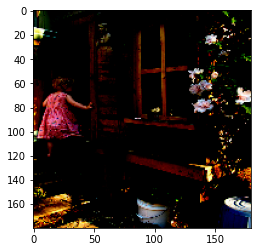

In [12]:
plt.imshow(load_image('1000268201_693b08cb0e.jpg')[0].numpy())

### Get images and labels from filenames

In [13]:
def get_images_labels(image_filenames):
    images = []
    labels = []
    
    for image_filename in image_filenames:
        image = images_dict[image_filename]
        captions = images_captions_dict[image_filename]

        for caption in captions:
            images.append(image)
            labels.append(caption)
            
    return images, labels

### Generate train and test set

In [14]:
image_filenames = list(images_captions_dict.keys())
image_filenames_train, image_filenames_test = train_test_split(image_filenames, test_size=validation_split, random_state=1)

X_train, y_train_raw = get_images_labels(image_filenames_train)
X_test, y_test_raw = get_images_labels(image_filenames_test)

In [15]:
image_filenames_test
print(X_test[0])
print(y_test_raw[0])

[[[1.1967934  0.01775184 1.090889   ... 0.         0.         3.582157  ]
  [3.4059598  0.         1.1769686  ... 0.         0.2806896  3.1625657 ]
  [4.0726576  0.63783026 0.6861656  ... 0.         0.553277   2.1792665 ]
  [3.0877576  0.         1.6168357  ... 0.         1.0671302  1.3340291 ]]

 [[2.1827896  0.5625806  1.4880495  ... 0.         0.37651938 2.285981  ]
  [4.1536126  0.         2.6608953  ... 0.         0.92405194 1.9472364 ]
  [3.811234   1.6717792  2.9226506  ... 0.         0.941192   0.92935926]
  [1.5026542  0.         0.99196255 ... 0.         1.2738587  0.4359707 ]]

 [[1.5001415  0.7009584  0.31314382 ... 0.         1.2390478  1.5326316 ]
  [3.0679328  0.35969463 2.824754   ... 0.         1.6123786  1.3334314 ]
  [1.1604468  0.         1.9159185  ... 0.         1.5444152  0.5478425 ]
  [0.         0.         0.80970967 ... 0.         1.6436776  0.24544679]]

 [[0.         0.         0.7527782  ... 0.         1.9278967  0.41889155]
  [0.         0.         1.75734

In [16]:
get_images_labels(['1937104503_313d22a2d0.jpg'])

([array([[[0.        , 0.29045847, 0.        , ..., 0.        ,
           0.        , 1.2453138 ],
          [0.28923866, 0.        , 0.        , ..., 0.        ,
           0.        , 1.0823888 ],
          [0.77843344, 0.        , 0.        , ..., 0.        ,
           0.        , 0.8377495 ],
          [0.8514005 , 0.        , 0.19232452, ..., 0.        ,
           0.        , 0.7469227 ]],
  
         [[1.4785671 , 0.        , 0.        , ..., 0.        ,
           0.        , 1.0901586 ],
          [0.6890315 , 0.        , 0.        , ..., 0.        ,
           0.        , 1.0378335 ],
          [0.94363165, 0.02742937, 0.        , ..., 0.        ,
           0.        , 0.8910313 ],
          [1.06122   , 0.39870074, 0.        , ..., 0.        ,
           0.        , 0.6667319 ]],
  
         [[0.43650714, 0.20891133, 0.3488243 , ..., 0.        ,
           0.        , 1.0894411 ],
          [0.33910373, 0.        , 0.        , ..., 0.        ,
           0.        , 1.156

In [17]:
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

### Tokenize train labels
Generate a vocabulary and transform the train captions to a vector with their indices in the vocabulary [1].

In [18]:
top_k = 5000 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(y_train_raw)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

y_train = tokenizer.texts_to_sequences(y_train_raw)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

In [20]:
max_caption_length = max(len(t) for t in y_train)
print(max_caption_length)

35


### Example tokenization

In [21]:
[tokenizer.index_word[i] for i in y_train[1]]

['<start>',
 'a',
 'black',
 'dog',
 'is',
 'standing',
 'on',
 'a',
 'step',
 'next',
 'to',
 'a',
 'river',
 'at',
 'it',
 'shakes',
 'itself',
 'dry',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Generate Tensorflow dataset

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [23]:
X_train

[array([[[0.        , 0.29045847, 0.        , ..., 0.        ,
          0.        , 1.2453138 ],
         [0.28923866, 0.        , 0.        , ..., 0.        ,
          0.        , 1.0823888 ],
         [0.77843344, 0.        , 0.        , ..., 0.        ,
          0.        , 0.8377495 ],
         [0.8514005 , 0.        , 0.19232452, ..., 0.        ,
          0.        , 0.7469227 ]],
 
        [[1.4785671 , 0.        , 0.        , ..., 0.        ,
          0.        , 1.0901586 ],
         [0.6890315 , 0.        , 0.        , ..., 0.        ,
          0.        , 1.0378335 ],
         [0.94363165, 0.02742937, 0.        , ..., 0.        ,
          0.        , 0.8910313 ],
         [1.06122   , 0.39870074, 0.        , ..., 0.        ,
          0.        , 0.6667319 ]],
 
        [[0.43650714, 0.20891133, 0.3488243 , ..., 0.        ,
          0.        , 1.0894411 ],
         [0.33910373, 0.        , 0.        , ..., 0.        ,
          0.        , 1.1560401 ],
         [0.22

In [24]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Using prefetching: https://www.tensorflow.org/guide/data_performance#prefetching
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
X_train[0]

array([[[0.        , 0.29045847, 0.        , ..., 0.        ,
         0.        , 1.2453138 ],
        [0.28923866, 0.        , 0.        , ..., 0.        ,
         0.        , 1.0823888 ],
        [0.77843344, 0.        , 0.        , ..., 0.        ,
         0.        , 0.8377495 ],
        [0.8514005 , 0.        , 0.19232452, ..., 0.        ,
         0.        , 0.7469227 ]],

       [[1.4785671 , 0.        , 0.        , ..., 0.        ,
         0.        , 1.0901586 ],
        [0.6890315 , 0.        , 0.        , ..., 0.        ,
         0.        , 1.0378335 ],
        [0.94363165, 0.02742937, 0.        , ..., 0.        ,
         0.        , 0.8910313 ],
        [1.06122   , 0.39870074, 0.        , ..., 0.        ,
         0.        , 0.6667319 ]],

       [[0.43650714, 0.20891133, 0.3488243 , ..., 0.        ,
         0.        , 1.0894411 ],
        [0.33910373, 0.        , 0.        , ..., 0.        ,
         0.        , 1.1560401 ],
        [0.2237612 , 1.1426136 , 0.1

In [26]:
y_train[0]

array([ 3,  2, 17, 10, 19,  9,  8, 39,  6, 21,  4,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

In [27]:
for i in dataset:
    print(i)
    break

(<tf.Tensor: shape=(64, 4, 4, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 3.63569200e-01, 0.00000000e+00, ...,
          5.27287781e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.23457089e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          5.71124077e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.91405237e-01, 0.00000000e+00, ...,
          8.93438578e-01, 2.60406554e-01, 1.52870566e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.45914936e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.51449513e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.21229744e+00, 5.95303699e-02, 3.90498340e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.48288488e+

## Models Definition

### CNN Encoder

In [28]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim) 

    def call(self, x):
        x = self.flat(x)
        x = self.fc(x)
        return x

### RNN Decoder

In [29]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
            
        self.fc = tf.keras.layers.Dense(vocab_size)
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        embed = self.embedding(captions) 

        if verbose:
            print("Embed")
            print(embed.shape)

        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
        
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)

        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)

        output = self.fc(output)

        return output, memory_state, carry_state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Train Stage

In [30]:
units = embedding_dim = 512
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys()))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred, verbose=False):
    loss_ = loss_object(real, pred)
    
    if verbose:
        print("Loss")
        print(loss_)
    
    loss_ = tf.reduce_mean(loss_, axis = 1)
        
    if verbose:
        print("After Mean Axis 1")    
        print(loss_)

    return loss_

In [31]:
@tf.function
def train_step(img_tensor, target, verbose=False):    
    if verbose:
        print("Image tensor")
        print(img_tensor.shape)

        print("Target")
        print(target.shape)    

    dec_input = tf.convert_to_tensor(target[:, :-1])

    # Source: https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        if verbose:
            print("Features CNN")
            print(features)
            
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)        
        
        if verbose:
            print("Predictions RNN")
            print(predictions)
        
        caption_loss = loss_function(target, predictions)
        total_batch_loss = tf.reduce_sum(caption_loss) 
        mean_batch_loss = tf.reduce_mean(caption_loss) 

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(caption_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

### Checkpoint

In [32]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Start Training

In [34]:
loss_plot = []

In [35]:
for (batch, (img_tensor, target)) in enumerate(dataset):
    print(img_tensor)
    break

tf.Tensor(
[[[[4.94537562e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.20025885e+00 0.00000000e+00 0.00000000e+00 ... 1.49315232e-02
    1.34704739e-01 0.00000000e+00]
   [9.54451680e-01 0.00000000e+00 0.00000000e+00 ... 9.91330624e-01
    4.19099241e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60365975e+00
    7.03555524e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.17610335e-01
    2.48380318e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.12001801e-01
    4.17286396e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.30322278e+00
    4.26152527e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.04815161e+00 ... 1.63278031e+00
    5.12403309e-01 1.68353990e-01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.61951852e+00
    4.69617844e-01 1.25557876e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.556

In [36]:
EPOCHS = 5
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1
    start = time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
        total_loss += total_batch_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))
    
    print ('Total Loss {:.6f}'.format(total_loss))
    epoch_loss = total_loss / NUM_STEPS
    
    loss_plot.append(epoch_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Epoch 1 Batch 0 Batch Loss 1.5557
Total Loss 4842.633301
Epoch 1 Epoch Loss 96.852669
Time taken for 1 epoch 76.75759506225586 sec

Epoch 2 Batch 0 Batch Loss 1.3360
Total Loss 4458.151855
Epoch 2 Epoch Loss 89.163040
Time taken for 1 epoch 58.1516330242157 sec

Epoch 3 Batch 0 Batch Loss 1.3755
Total Loss 4232.947266
Epoch 3 Epoch Loss 84.658943
Time taken for 1 epoch 54.61608386039734 sec

Epoch 4 Batch 0 Batch Loss 1.2388
Total Loss 4057.606445
Epoch 4 Epoch Loss 81.152130
Time taken for 1 epoch 54.293089866638184 sec

Epoch 5 Batch 0 Batch Loss 1.1036
Total Loss 3905.791504
Epoch 5 Epoch Loss 78.115829
Time taken for 1 epoch 52.704943895339966 sec



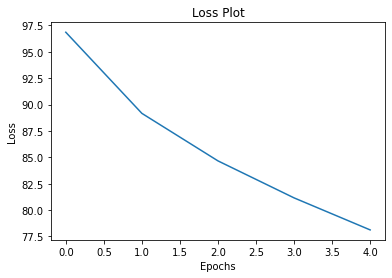

In [37]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Test Stage

In [38]:
def clean_caption(caption):
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

In [39]:
test_img_name = random.choice(image_filenames_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real captions
<start> A black and grey dog runs in a field with its tongue hanging out . <end>
<start> A black dog with a red collar runs through grass . <end>
<start> A black dog with a red collar walks through the grass with his mouth open and tongue hanging out . <end>
<start> A dog with a red collar and its tongue hanging out runs through tall grass . <end>
<start> A dog with red collar is running in the field . <end>
Esimated caption
['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'field']


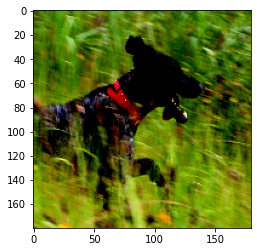

In [40]:
def get_caption(img):     
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    return clean_caption(caption)

raw_img = load_image(test_img_name)[0]
img = images_dict[test_img_name]

captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

print("Real captions")
for caption in captions:
    print(caption)

print("Esimated caption")
estimated_caption = get_caption(img)
print(estimated_caption)

### Evaluate dataset using BLEU

In [ ]:
def get_caption(img):    
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    return clean_caption(caption)

actual, predicted = [], []

for test_img_name in image_filenames_test:
    img = images_dict[test_img_name]
    estimated_caption = get_caption(img)

    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]]
    
    actual.append(captions)
    predicted.append(estimated_caption)

# Print BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.412082
BLEU-2: 0.196839


C:\Users\yadav\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
